In [0]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 


In [0]:
!pip install --upgrade pip
!pip uninstall kaggle
!pip install kaggle

In [0]:
import os 
import sys

import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob 

In [0]:


#enter your Kaggle credentionals here

import os
os.environ['KAGGLE_USERNAME'] = "XXXX" # username from the json file
os.environ['KAGGLE_KEY'] = "XXX" # key from the json file

if '.kaggle' not in os.listdir('/root'):
    !mkdir ~/.kaggle

#Root directory of the project
ROOT_DIR = os.path.abspath('./kaggle-rsna-data')

if not os.path.exists(ROOT_DIR): os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

#Directory to save logs and trained model
MODELDIR = os.path.join(ROOT_DIR, 'logs')
if not os.path.exists(MODELDIR): os.makedirs(MODELDIR)


!kaggle competitions download -c rsna-pneumonia-detection-challenge 



100% 3.66G/3.66G [01:03<00:00, 58.6MB/s]
100% 3.66G/3.66G [01:03<00:00, 61.7MB/s]


In [0]:

!unzip /content/kaggle-rsna-data/kaggle-rsna-data/rsna-pneumonia-detection-challenge.zip
#!unzip rsna-pneumonia-detection-challenge.zip

Streaming output truncated to the last 5000 lines.
  inflating: stage_2_train_images/ead9646b-d109-4ac6-b4f7-340fca8a274b.dcm  
  inflating: stage_2_train_images/eadab655-474b-4bdf-9018-0adb6dbed310.dcm  
  inflating: stage_2_train_images/eadbf3c9-f034-4b29-9a46-b90a16978a2a.dcm  
  inflating: stage_2_train_images/eadd2c1c-2e56-4392-85dc-2c4fe8a9d420.dcm  
  inflating: stage_2_train_images/eadd617b-818b-4692-8c47-13ea979ad296.dcm  
  inflating: stage_2_train_images/eadd770e-f476-4472-aad5-bc6dd92c5e02.dcm  
  inflating: stage_2_train_images/eade2cca-dc25-404f-85a9-3da7772c2b7e.dcm  
  inflating: stage_2_train_images/eae2ac78-a276-48a5-8d15-1d2c89f10ea4.dcm  
  inflating: stage_2_train_images/eae36cd8-b173-4eee-b989-db0f42e1a850.dcm  
  inflating: stage_2_train_images/eae43926-5ed5-41c0-bb4f-e248e2b22f3a.dcm  
  inflating: stage_2_train_images/eae4b4ba-6199-4393-99d3-78ac3e10beea.dcm  
  inflating: stage_2_train_images/eae9deb3-2bf7-4e52-aa43-e36b60cc676a.dcm  
  inflating: stage_2_trai

In [0]:
# Import libraries
import os
import random
import csv
import pydicom
import numpy as np
import pandas as pd
from skimage import io
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches
import keras
from keras.engine import Input, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Activation, BatchNormalization, PReLU, Deconvolution2D
from keras.optimizers import Adam
from keras.layers.merge import concatenate
# Set the image shape to have the channels in the first dimension
from keras import backend as K
K.set_image_data_format("channels_first")


from keras.models import Model
from keras.models import  Sequential
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend.tensorflow_backend as tfback

In [0]:
DATA_DIR = '/content/kaggle-rsna-data/kaggle-rsna-data/'

In [0]:
# Directory of training, label, and testing images
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
label_path = os.path.join(DATA_DIR, 'stage_2_train_labels.csv')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

In [0]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(label_path, mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [0]:
# load and shuffle filenames
folder = train_dicom_dir
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 24124
n valid samples 2560


In [0]:
# original DICOM image size: 1024 x 1024
orig_size = 1024
new_size = 256
img_channels = 3

# batch size
batch_size = 32

# epochs 
epochs_num = 25

# number of threads specified in workers are those that generate batches in parallel
workers_num = 4

In [0]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=256, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [0]:
# Set hyper-parameters
num_channels = 1
height = 256
width = 256
filter_num = 32

The shape of the input layer is (num_channels, height, width), where num_channels you can think of like color channels in an image, height, and width are just the size of the input.

In [0]:
def get_unet(n_ch,patch_height,patch_width):
    concat_axis = 3

    inputs = Input((patch_height, patch_width, n_ch))
    
    conv1 = Conv2D(32, (3, 3), padding="same", name="conv1_1", activation="relu", data_format="channels_last")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv2)

    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(conv4)

    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu", data_format="channels_last")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv5)
    up_conv5 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv5)
    
    up6   = concatenate([up_conv5, conv4], axis=concat_axis)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv6)

    up_conv6 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv6)
    
    up7   = concatenate([up_conv6, conv3], axis=concat_axis)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv7)

    up_conv7 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv7)
    
    
    up8   = concatenate([up_conv7,conv2], axis=concat_axis)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv8)

    up_conv8 = UpSampling2D(size=(2, 2), data_format="channels_last")(conv8)
    
    up9   = concatenate([up_conv8, conv1], axis=concat_axis)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu", data_format="channels_last")(conv9)

    #ch, cw = get_crop_shape(inputs, conv9)
    #conv9  = ZeroPadding2D(padding=(ch[0],cw[0]), data_format="channels_last")(conv9)
    conv10 = Conv2D(1, (1, 1), data_format="channels_last", activation="sigmoid")(conv9)
    
       
    model = Model(input=inputs, output=conv10)
    
    return model

In [0]:
# define iou or jaccard loss function
# intersection over Union(Iou) is a function that quantifies how correctly positioned a predicted bounding box 


def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

   

model = get_unet(num_channels, height, width)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = epochs_num
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = train_dicom_dir
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size= batch_size, image_size= new_size, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size= batch_size, image_size= new_size, shuffle=False, predict=False)

history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs= epochs_num, workers= workers_num, use_multiprocessing=True)
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


Epoch 1/25
753/753 [==============================] - 1969s 3s/step - loss: 0.5097 - accuracy: 0.9640 - mean_iou: 0.5606 - val_loss: 0.4892 - val_accuracy: 0.9324 - val_mean_iou: 0.2993
Epoch 2/25
753/753 [==============================] - 1941s 3s/step - loss: 0.4619 - accuracy: 0.9637 - mean_iou: 0.5635 - val_loss: 0.4571 - val_accuracy: 0.9699 - val_mean_iou: 0.6352
Epoch 3/25
753/753 [==============================] - 1940s 3s/step - loss: 0.4473 - accuracy: 0.9658 - mean_iou: 0.6033 - val_loss: 0.4552 - val_accuracy: 0.9712 - val_mean_iou: 0.6849
Epoch 3/25
Epoch 4/25
753/753 [==============================] - 1957s 3s/step - loss: 0.4363 - accuracy: 0.9673 - mean_iou: 0.6299 - val_loss: 0.4112 - val_accuracy: 0.9684 - val_mean_iou: 0.6266
Epoch 5/25
753/753 [==============================] - 1953s 3s/step - loss: 0.4277 - accuracy: 0.9681 - mean_iou: 0.6396 - val_loss: 0.4258 - val_accuracy: 0.9702 - val_mean_iou: 0.6681
Epoch 6/25
753/753 [==============================] - 1946s

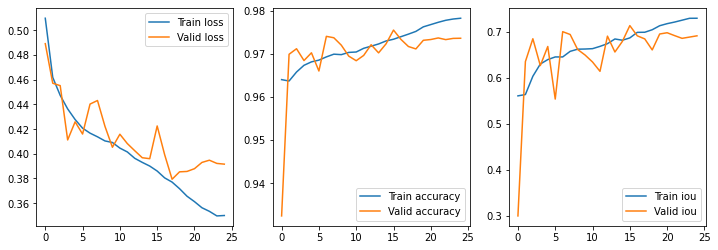

In [0]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_accuracy"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

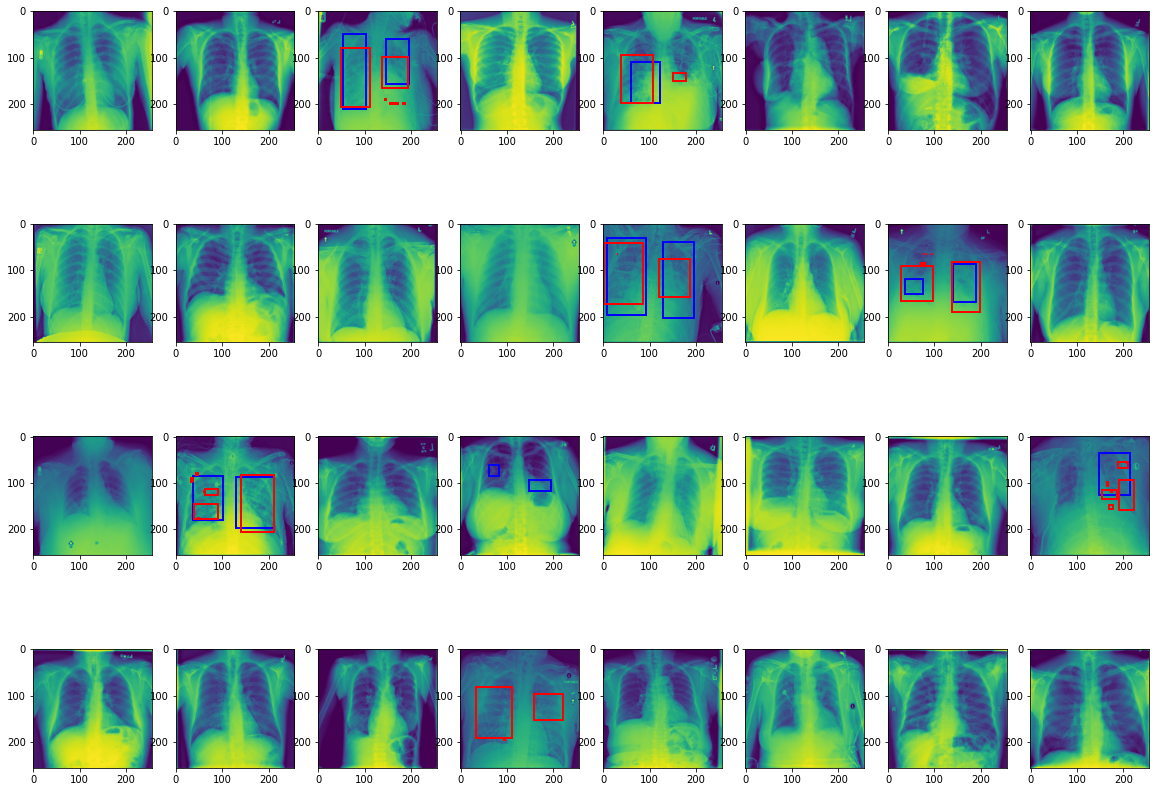

In [0]:
for imgs, msks in valid_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # create figure
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])
        # threshold true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='b',facecolor='none'))
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle((x,y),width,height,linewidth=2,edgecolor='r',facecolor='none'))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [0]:
# load and shuffle filenames
folder = test_dicom_dir
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=25, image_size= new_size, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    # predict batch of images
    preds = model.predict(imgs)
    # loop through batch
    for pred, filename in zip(preds, filenames):
        # resize predicted mask
        pred = resize(pred, (1024, 1024), mode='reflect')
        # threshold predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        predictionString = ''
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            # add to predictionString
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(width) + ' ' + str(height) + ' '
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break

# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('submission.csv')

n test samples: 3000
